In [1]:
import warnings
warnings.filterwarnings("ignore")

import string
import keras
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from plotly import graph_objs as go
from plotly import express as px
from plotly import figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
! pip install bs4
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
from keras.callbacks import ReduceLROnPlateau

from string import punctuation
from nltk.tokenize.toktok import ToktokTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

     |████████████████████████████████| 115 kB 837 kB/s 
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=10a526b14113cc920497ecee4f7402b9fd437483337c3e94b0331ea8a01c66c0
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


In [2]:
primary_blue = "#496595";primary_blue2 = "#85a1c1";primary_blue3 = "#3f4d63";primary_grey = "#c6ccd8";

# Data Exploration

In [3]:
sms = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin-1')
sms

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [7]:
sms['messagelen'] = sms.message.apply(len)
sms.head()

,label,message,messagelen
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [8]:
sms[sms.label=='ham'].describe()

,messagelen
count,4825.000000
mean,71.023627
std,58.016023
min,2.000000
25%,33.000000
50%,52.000000
75%,92.000000
max,910.000000


In [9]:
sms[sms.label=='spam'].describe()

,messagelen
count,747.000000
mean,138.866131
std,29.183082
min,13.000000
25%,132.500000
50%,149.000000
75%,157.000000
max,224.000000


In [10]:
balance_counts = sms.groupby('label')['label'].agg('count').values
balance_counts

array([4825,  747])

# Data Visulaization

In [11]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

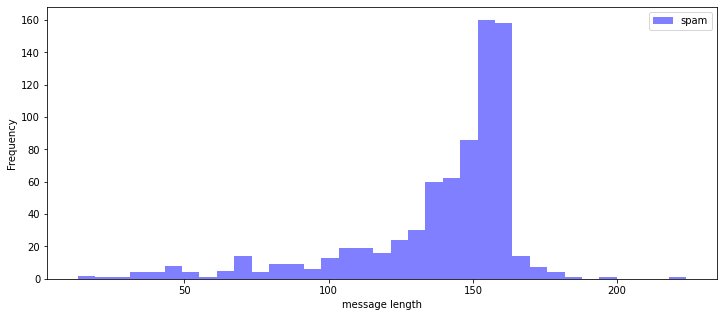

In [12]:
plt.figure(figsize=(12,5))
sms[sms['label']=='spam']['messagelen'].plot(bins=35,kind='hist',color='blue',label='spam',alpha=0.5)
plt.legend()
plt.xlabel('message length')
plt.show()

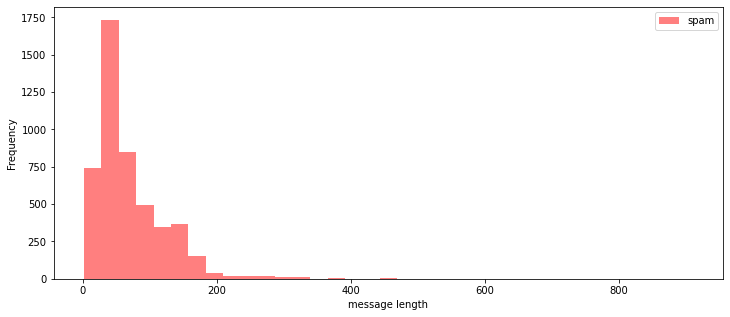

In [13]:
plt.figure(figsize=(12,5))
sms[sms['label']=='ham']['messagelen'].plot(bins=35,kind='hist',color='red',label='spam',alpha=0.5)
plt.legend()
plt.xlabel('message length')
plt.show()

In [14]:
df=sms.copy()
df.label.replace("ham",0,inplace = True)
df.label.replace("spam",1,inplace = True)
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Data Cleaning Indepth 

In [15]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            if i.strip().isalpha():
                final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_stopwords(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['message']=df['message'].apply(denoise_text)

# EDA

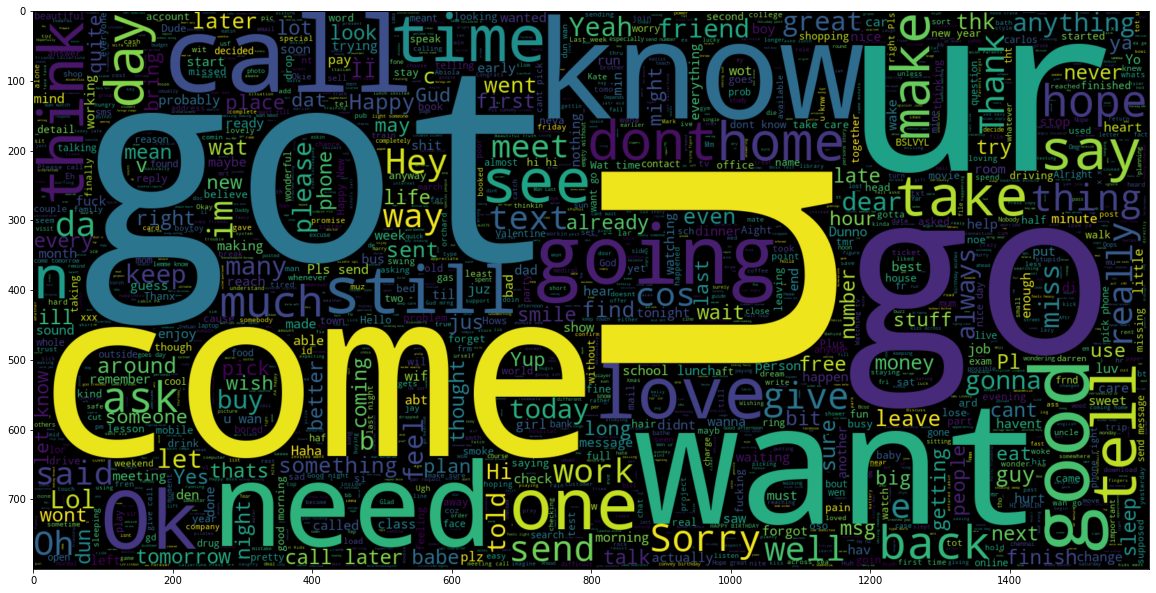

In [16]:
plt.figure(figsize = (20,20)) # Text that is not Spam
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 0].message))
plt.imshow(wc , interpolation = 'bilinear')

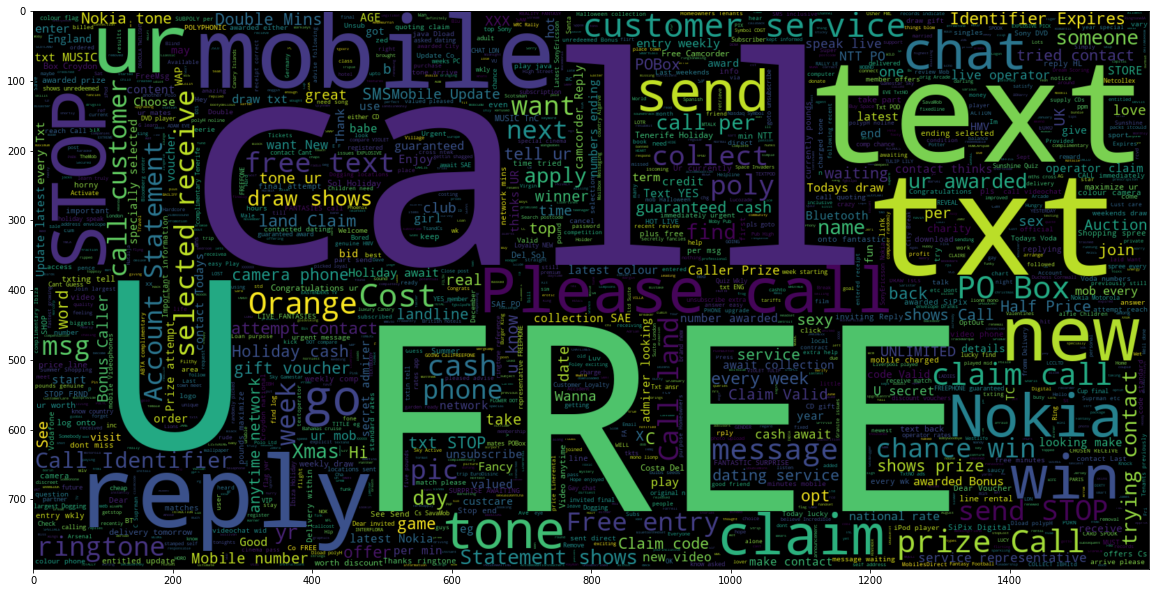

In [17]:
plt.figure(figsize = (20,20)) # Text that is Spam
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 1].message))
plt.imshow(wc , interpolation = 'bilinear')

Text(0.5, 0.98, 'Average word length in each text')

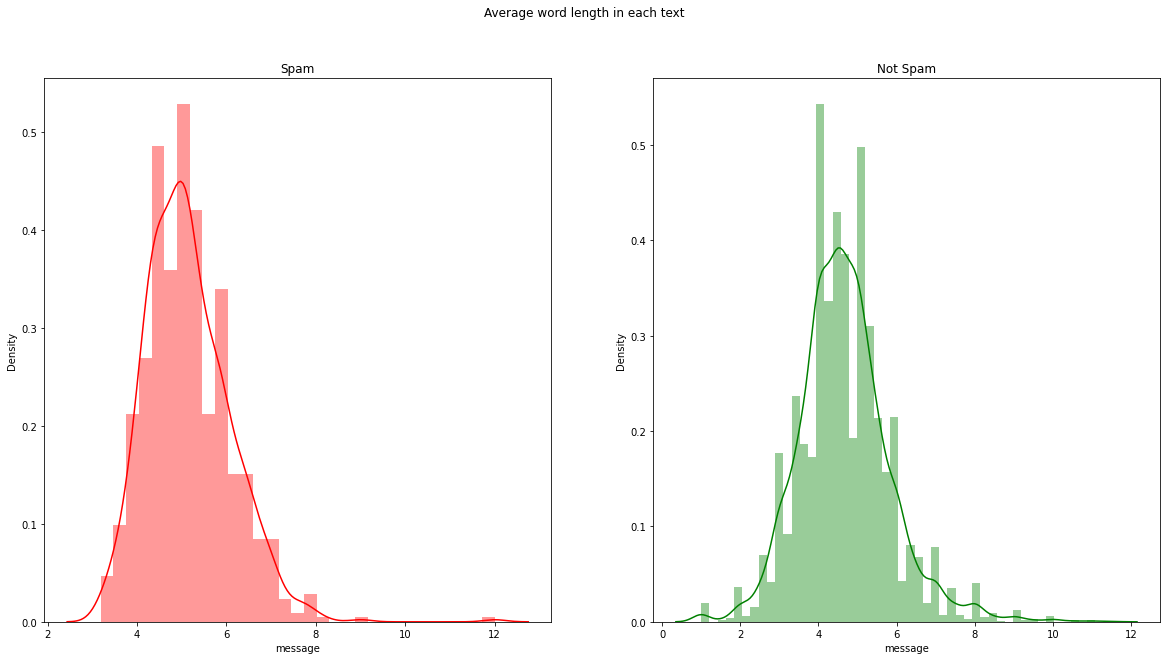

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['label']==1]['message'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Spam')
word=df[df['label']==0]['message'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Spam')
fig.suptitle('Average word length in each text')

**lets perform stemming or lemmetzation and vectorization** 

In [19]:
df1=df.copy()

In [20]:
ps = PorterStemmer() # Using porterstemmer for text preprocessing
message = []
for i in range(0, df1.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df1['message'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    message.append(review)

In [21]:
df1['clean_msg']=np.empty((len(message),1))
for i in range(len(message)):
    df1['clean_msg'][i]=message[i]
df1['clean_msg_len']=df1['clean_msg'].apply(len)
df1.head()

,label,message,messagelen,clean_msg,clean_msg_len
0,0,Go jurong Available bugis n great world la e C...,111,go jurong avail bugi n great world la e cine g...,53
1,0,Ok Joking wif u,29,ok joke wif u,13
2,1,Free entry wkly comp win FA Cup final tkts May...,155,free entri wkli comp win fa cup final tkt may ...,76
3,0,U dun say early U c already,49,u dun say earli u c alreadi,27
4,0,Nah think goes lives around though,61,nah think goe live around though,32


In [22]:
X=df1['clean_msg']
Y=df1['label']

In [23]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(message).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
Y=np.array(Y)
type(Y)

numpy.ndarray

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 0)


In [26]:
print("X_train shape: {}\n X_test shape: {}\nY_train shape: {}\nY_test shape: {}".format(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape))

X_train shape: (5014, 2500)
 X_test shape: (558, 2500)
Y_train shape: (5014,)
Y_test shape: (558,)


In [27]:
acc=[]

# Ml algorithms

In [28]:
spam_detect_model = MultinomialNB().fit(X_train, Y_train)
pred=spam_detect_model.predict(X_test)

print("Accuracy of Naive Bayes Classifier is: {}".format(metrics.accuracy_score(Y_test,pred)))
acc.append(metrics.accuracy_score(Y_test,pred))

Accuracy of Naive Bayes Classifier is: 0.9605734767025089


In [29]:
LR=LogisticRegression(solver='liblinear')
LR.fit(X_train,Y_train)
yhat = LR.predict(X_test)
print("LogisticRegression's Accuracy:{0}".format(metrics.accuracy_score(Y_test, yhat)))
acc.append(metrics.accuracy_score(Y_test,yhat))

LogisticRegression's Accuracy:0.9731182795698925


In [30]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, Y_train) 
yhat = clf.predict(X_test)
print("SVM's Accuracy:{0}".format(metrics.accuracy_score(Y_test, yhat)))
acc.append(metrics.accuracy_score(Y_test, yhat))

SVM's Accuracy:0.96415770609319


In [31]:
Random_forest = RandomForestClassifier(n_estimators=50)
Random_forest.fit(X_train,Y_train)
randomForest_predict = Random_forest.predict(X_test)
randomForest_score = metrics.accuracy_score(Y_test, randomForest_predict)
print("Random Forest Score :",randomForest_score)
acc.append(metrics.accuracy_score(Y_test,randomForest_predict ))

Random Forest Score : 0.9695340501792115


In [32]:
gbk = GradientBoostingClassifier(random_state=100, n_estimators=150,min_samples_split=100, max_depth=6)
gbk.fit(X_train, Y_train)
gbk_predict = gbk.predict(X_test)
print("Gradient Boosting Score :",metrics.accuracy_score(Y_test,gbk_predict ))
acc.append(metrics.accuracy_score(Y_test,gbk_predict ))

Gradient Boosting Score : 0.956989247311828


In [33]:
mx=-1
for i in range(1,25):
    
    neigh=KNeighborsClassifier(n_neighbors = i).fit(X_train,Y_train)
    yhat = neigh.predict(X_test)
    KNN_score=metrics.accuracy_score(Y_test, yhat)
    print("KNN Accuracy at {} is {}".format(i,KNN_score))
    mx=max(mx,KNN_score)
    print("\n")
acc.append(mx)
mx

KNN Accuracy at 1 is 0.9480286738351255


KNN Accuracy at 2 is 0.9157706093189965


KNN Accuracy at 3 is 0.9229390681003584


KNN Accuracy at 4 is 0.9086021505376344


KNN Accuracy at 5 is 0.910394265232975


KNN Accuracy at 6 is 0.8924731182795699


KNN Accuracy at 7 is 0.8924731182795699


KNN Accuracy at 8 is 0.8835125448028673


KNN Accuracy at 9 is 0.8835125448028673


KNN Accuracy at 10 is 0.8763440860215054


KNN Accuracy at 11 is 0.8763440860215054


KNN Accuracy at 12 is 0.8691756272401434


KNN Accuracy at 13 is 0.8691756272401434


KNN Accuracy at 14 is 0.8620071684587813


KNN Accuracy at 15 is 0.8637992831541219


KNN Accuracy at 16 is 0.8602150537634409


KNN Accuracy at 17 is 0.8602150537634409


KNN Accuracy at 18 is 0.8566308243727598


KNN Accuracy at 19 is 0.8584229390681004


KNN Accuracy at 20 is 0.8566308243727598


KNN Accuracy at 21 is 0.8566308243727598


KNN Accuracy at 22 is 0.8566308243727598


KNN Accuracy at 23 is 0.8566308243727598


KNN Accuracy at 24 is

0.9480286738351255

Text(0, 0.5, 'Accuracy')

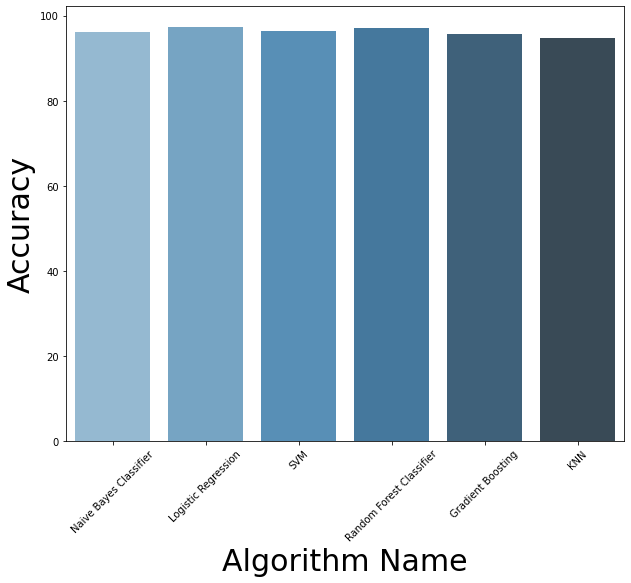

In [34]:
algo_name=['Naive Bayes Classifier','Logistic Regression','SVM','Random Forest Classifier','Gradient Boosting','KNN']
acc=np.array(acc)
from numpy import median
plt.figure(figsize=(10,8))
sns.barplot(y=acc*100,x=algo_name,estimator=median,palette="Blues_d")
plt.xlabel('Algorithm Name',size=30)
plt.xticks(rotation=45)
plt.ylabel('Accuracy',size=30)

In [35]:
x_train,x_test,y_train,y_test = train_test_split(df.message,df.label,random_state = 0)

In [36]:
max_features = 4000
maxlen = 50
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

# Glove method

In [37]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [38]:
EMBEDDING_FILE = '../input/twitter-embeded/glove.twitter.27B.50d.txt'
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [39]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, 50))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [40]:
batch_size = 64
epochs = 5
embed_size = 50

In [41]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length = maxlen, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128, return_sequences = True)))
model.add(Bidirectional(GRU(units=32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 439,041
Trainable params: 439,041
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs =20)

Epoch 1/20
66/66 [==============================] - 20s 209ms/step - loss: 0.3129 - accuracy: 0.8764 - val_loss: 0.1357 - val_accuracy: 0.9548
Epoch 2/20
66/66 [==============================] - 12s 178ms/step - loss: 0.1214 - accuracy: 0.9564 - val_loss: 0.1071 - val_accuracy: 0.9648
Epoch 3/20
66/66 [==============================] - 12s 182ms/step - loss: 0.0878 - accuracy: 0.9758 - val_loss: 0.0992 - val_accuracy: 0.9698
Epoch 4/20
66/66 [==============================] - 12s 178ms/step - loss: 0.0641 - accuracy: 0.9824 - val_loss: 0.0878 - val_accuracy: 0.9720
Epoch 5/20
66/66 [==============================] - 12s 180ms/step - loss: 0.0523 - accuracy: 0.9846 - val_loss: 0.0871 - val_accuracy: 0.9713
Epoch 6/20
66/66 [==============================] - 12s 182ms/step - loss: 0.0386 - accuracy: 0.9902 - val_loss: 0.0869 - val_accuracy: 0.9734
Epoch 7/20
66/66 [==============================] - 12s 177ms/step - loss: 0.0280 - accuracy: 0.9936 - val_loss: 0.0876 - val_accuracy: 0.9734

In [44]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

44/44 [==============================] - 2s 40ms/step - loss: 0.1127 - accuracy: 0.9799
Accuracy of the model on Testing Data is -  97.9899525642395 %


In [45]:
pred = model.predict_classes(x_test)
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [46]:
print(classification_report(y_test, pred, target_names = ['Not Spam','Spam']))

              precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99      1196
        Spam       0.94      0.91      0.93       197

    accuracy                           0.98      1393
   macro avg       0.96      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [47]:
cm = confusion_matrix(y_test,pred)
cm

array([[1185,   11],
       [  17,  180]])

In [48]:
cm = pd.DataFrame(cm , index = ['Not Spam','Spam'] , columns = ['Not Spam','Spam'])

<AxesSubplot:>

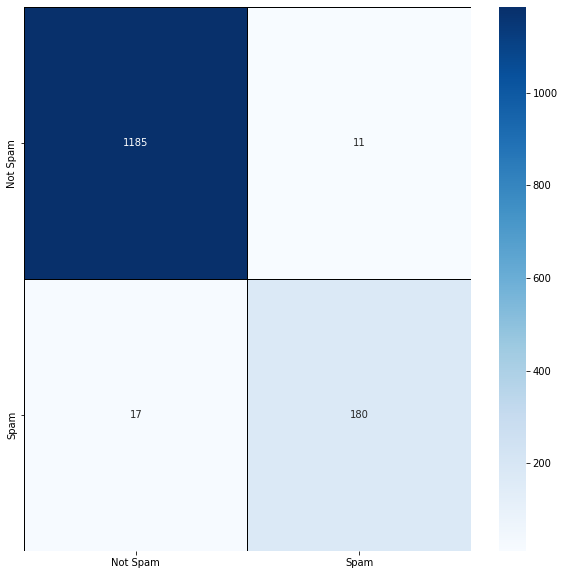

In [49]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Spam','Spam'] , yticklabels = ['Not Spam','Spam'])

# RNN

In [50]:
df2= pd.read_csv('../input/sms-spam-collection-dataset/spam.csv',delimiter=',',encoding='latin-1')
df2.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [51]:
X1= df2.v2
Y1 = df2.v1
le = LabelEncoder()
Y1= le.fit_transform(Y)
Y1 = Y1.reshape(-1,1)

In [52]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X1,Y1,test_size=0.15)

In [53]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(Xtrain)
sequences = tok.texts_to_sequences(Xtrain)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [54]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [55]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [56]:
model.fit(sequences_matrix,Ytrain,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 9s 234ms/step - loss: 0.4302 - accuracy: 0.8562 - val_loss: 0.1254 - val_accuracy: 0.9673
Epoch 2/10
30/30 [==============================] - 6s 209ms/step - loss: 0.1057 - accuracy: 0.9758 - val_loss: 0.0512 - val_accuracy: 0.9884
Epoch 3/10
30/30 [==============================] - 6s 206ms/step - loss: 0.0512 - accuracy: 0.9842 - val_loss: 0.0401 - val_accuracy: 0.9884
Epoch 4/10
30/30 [==============================] - 6s 208ms/step - loss: 0.0368 - accuracy: 0.9879 - val_loss: 0.0407 - val_accuracy: 0.9895


In [57]:
test_sequences = tok.texts_to_sequences(Xtest)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [58]:
accr = model.evaluate(test_sequences_matrix,Ytest)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

27/27 [==============================] - 1s 23ms/step - loss: 0.0618 - accuracy: 0.9868
Test set
  Loss: 0.062
  Accuracy: 0.987


In [59]:
df1

,label,message,messagelen,clean_msg,clean_msg_len
0,0,Go jurong Available bugis n great world la e C...,111,go jurong avail bugi n great world la e cine g...,53
1,0,Ok Joking wif u,29,ok joke wif u,13
2,1,Free entry wkly comp win FA Cup final tkts May...,155,free entri wkli comp win fa cup final tkt may ...,76
3,0,U dun say early U c already,49,u dun say earli u c alreadi,27
4,0,Nah think goes lives around though,61,nah think goe live around though,32
...,...,...,...,...,...
5567,1,time tried contact U Pound claim call per,161,time tri contact u pound claim call per,39
5568,0,b going esplanade fr,37,b go esplanad fr,16
5569,0,mood,57,mood,4
5570,0,guy bitching acted like interested buying some...,125,guy bitch act like interest buy someth els nex...,65


In [60]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df1['clean_msg'], df1['label'], test_size = 0.3, random_state=0, shuffle = True, stratify=df1['label'])

In [61]:
Xtrain

3467                     final miss cinema trip last week
1164                             im time make oreo truffl
5059                                     think disturb da
1721    watch hous entertain get whole hugh lauri thin...
1921                               current food alon also
                              ...                        
4547                                      hope good check
1235    opinion jada kusruthi lovabl silent spl charac...
3361                                          messag hold
1798                               one week leav put know
1454                           decid faster co si go home
Name: clean_msg, Length: 3900, dtype: object

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
def tfidf(data):
    tfidf_vec = TfidfVectorizer()
    tfidf_model = tfidf_vec.fit(data)
    print(tfidf_model.dtype)
    X_tfidf = tfidf_model.transform(data)
    return X_tfidf

In [64]:
tfidf(Xtrain)

<class 'numpy.float64'>


<3900x4075 sparse matrix of type '<class 'numpy.float64'>'
	with 23309 stored elements in Compressed Sparse Row format>

In [65]:
clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])

In [66]:
clf.fit(Xtrain,ytrain)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(n_jobs=-1))])

In [67]:
! pip install gradio

     |████████████████████████████████| 2.5 MB 860 kB/s 
     |████████████████████████████████| 1.9 MB 5.1 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4709 sha256=a139cefb88144a7d4d29f2ba24ae5d6a4fd38327a0b23e711739feb7279305f7
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3372 sha256=86b73f4d196cc0f18023667158a179896c0ad0a9f8dc23b0bb32673260f4ca58
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [68]:
import gradio as gr
counter = 0
def prdict(mssg):
    ans=clf.predict([mssg])
    ans=list(ans);ans=ans[0];
    if ans==0:
        s="Ham"
        return s
    else:
        f="Spam"
        return f
iface = gr.Interface(fn=prdict, inputs="text", outputs="text")
iface.launch(share=True)

Running locally at: http://127.0.0.1:7860/
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://29200.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://29200.gradio.app')